<a href="https://colab.research.google.com/github/LeoFernanndes/portfolio/blob/master/Twitter_Scaping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install mysql-connector-python
!pip install pymysql
!pip install tweepy

In [33]:
import pandas as pd
import json
import mysql.connector
import os
import tweepy as tw
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option("display.max_rows", 500)

In [13]:
def twitter_authentication(twitter_api_credentials):

  auth = tw.OAuthHandler(consumer_key = twitter_api_credentials['consumer_key'],
                         consumer_secret = twitter_api_credentials['consumer_secret'])
  
  auth.set_access_token(twitter_api_credentials['access_token'],
                        twitter_api_credentials['access_secret'])
  
  api = tw.API(auth, wait_on_rate_limit=True)
  
  return api

In [27]:
def mysql_rds_database_authentication(database_credentials, database):
  
  mydb = mysql.connector.connect(
    host = database_credentials['host'],
    user = database_credentials['user'],
    port = database_credentials['port'],
    password = database_credentials['password'],
    database = database
  )

  return mydb

In [16]:
twitter_database_credentials = open("twitter_database_credentials.json")
twitter_database_credentials = json.load(twitter_database_credentials)

mydb = mysql_rds_database_authentication(twitter_database_credentials)

cursor = mydb.cursor()

cursor.execute(
    """
    USE twitter_data
    """
)

cursor.execute(
    """
    CREATE TABLE IF NOT EXISTS `executed_queries` (
      query VARCHAR(100) PRIMARY KEY,
      date DATETIME,
      value TEXT,
      retrieved_tweets INT,
      minutes_to_retrieve INT
    );
    """
)

cursor.execute(
    """
    CREATE TABLE IF NOt EXISTS `tweets` (
      id VARCHAR(50) PRIMARY KEY,
      name TEXT,
      arroba TEXT,
      retweetS INT,
      likes INT,
      text TEXT,
      date DATETIME,
      location TEXT,
      hashtags TEXT,
      links TEXT,
      language TEXT,
      search TEXT
    );
    """
)


twitter_api_credentials = open("twitter_keys.json")
twitter_api_credentials = json.load(twitter_api_credentials)

api = twitter_authentication(twitter_api_credentials)

# definindo a busca
search_words_list = ["carapicuíba"]

for word in search_words_list:

  dias = 6

  for i in range(dias):

    start = datetime.now()

    inicio = (datetime.today() - timedelta(days=((dias-i)-1), hours=3)).date()
    final = (datetime.today() - timedelta(days=((dias-i)-2), hours=3)).date()

    df = pd.read_sql("SELECT * FROM executed_queries", con=mydb)

    query = "{} - {} - {}".format(word, inicio, final)

    if query not in list(df["query"]):

      search_word = word
      date_since = inicio
      date_until = final

      tweets = tw.Cursor(api.search,
                        q=search_word,
                        tweet_mode="extended",
                        since=date_since,
                        until=date_until).items()

      count = 0

      for tweet in tweets:
        if hasattr(tweet, "quoted_status"):
          full_text = "QT {} \n QUOTED: {}".format(tweet.full_text, tweet.quoted_status.full_text)    
        if hasattr(tweet, "retweeted_status") is False:
          full_text = "{}".format(tweet.full_text)
        if hasattr(tweet, "retweeted_status") is True:
          full_text = "RT @{}: {}".format(tweet.retweeted_status.user.screen_name, tweet.retweeted_status.full_text)
       
        sql =  """
          INSERT IGNORE INTO `tweets` (id, name, arroba, retweets, likes, text, date, location, hashtags, links, language, search)
          VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
          """

        cursor.execute(
              sql, (tweet.id_str, tweet.user.name, tweet.user.screen_name, tweet.retweet_count, tweet.favorite_count, full_text,
                    tweet.created_at - timedelta(hours=3), tweet.user.location, str(tweet.entities.get("hashtags")), str(tweet.entities.get("urls")), tweet.lang, word)
          )

        count += 1

      mydb.commit()

      end = datetime.now()
      time = end - start
      minutes = time.seconds / 60

      if i != dias - 1:
        query_sql = """
          INSERT IGNORE INTO `executed_queries` (query, date, value, retrieved_tweets, minutes_to_retrieve)
          VALUES (%s, %s, %s, %s, %s)
        """
        cursor.execute(
            query_sql, ("{} - {} - {}".format(word, inicio, final), datetime.now(), word, count, np.round(minutes, 6))
        )

        mydb.commit()       

      print("{}: {} - {} retrieved {} in {}".format(word, inicio, final, count, np.round(time.seconds / 60, 4)))

mydb.close()

carapicuíba: 2020-12-16 - 2020-12-17 retrieved 114 in 0.1333


In [30]:
twitter_database_credentials = open("twitter_database_credentials.json")
twitter_database_credentials = json.load(twitter_database_credentials)

mydb = mysql_rds_database_authentication(twitter_database_credentials, 'twitter_data')

df_tweets = pd.read_sql("SELECT * FROM tweets where search = 'bolsonaro';", con=mydb)
df_tweets.sort_values(by=['date'], ascending=False).iloc[0:10]

,id,name,arroba,retweetS,likes,text,date,location,hashtags,links,language,search
1273599,1339364889232588800,Bismarck the grey,bismarckllv,0,0,"@rodrigovalamiel @jucerasoli Olha, sou eleitor...",2020-12-16 21:20:48,,[],[],pt,bolsonaro
1273598,1339364887894634499,Deise Peres. oficial 🇧🇷,DeisePeres4,0,0,MEU APOIO À BOLSONARO ESTÁ COM OS DIAS CONTADO...,2020-12-16 21:20:48,"Rio de Janeiro, Brasil",[],[],pt,bolsonaro
1273597,1339364887328411650,fabio paiva fagundes,Fabiopf08Fabio,181,0,RT @zehdeabreu: Sou antigo: tirar Bolsonaro e ...,2020-12-16 21:20:47,,[],[],pt,bolsonaro
1273596,1339364886279798786,Pachakutiy 🇧🇴🇦🇷🇺🇾🇻🇳🇨🇳🇹🇱🇻🇪🇨🇺🇲🇿,DeiNikkolo,5,0,"RT @luisnassif: ""O segundo ponto foi o (Alexan...",2020-12-16 21:20:47,,[],[],pt,bolsonaro
1273595,1339364881947119616,Marcos Almeida 🐔,MarcosMidias,954,0,RT @felipeneto: Genocida. Monstro.\n\nEste des...,2020-12-16 21:20:46,"Itabira, Brasil",[],[],pt,bolsonaro
1273594,1339364881905102849,Deyvid Bacelar,deyvidbacelar,0,0,"#REPOST @estadao😷 Mascarado, Zé Gotinha recusa...",2020-12-16 21:20:46,Feira de Santana,"[{'text': 'REPOST', 'indices': [0, 7]}]",[],pt,bolsonaro
1273593,1339364875781480451,JaneCleideQ🔰Ⓜ,JanecleideQ,0,0,@g1 Pazuello e Bolsonaro sao a tampa e a panel...,2020-12-16 21:20:45,"Teresina, Brasil",[],[],pt,bolsonaro
1273591,1339364872711233538,👉💩 #EuNãoVoteiNele,EmersonDaviB,894,0,RT @MarceloFreixo: O Zé Gotinha de máscara rec...,2020-12-16 21:20:44,"Rio de Janeiro, Brasil",[],[],pt,bolsonaro
1273589,1339364871222210560,Senziani,CSenziani,3578,0,"RT @P_droMenezes: Até agora, Bolsonaro privati...",2020-12-16 21:20:44,"Rio de Janeiro, Brasil",[],[],pt,bolsonaro
1273590,1339364871889162242,Fernando Santos - 🇧🇷 🇺🇸,Fernand57903209,1,0,RT @CristianeCentu6: Dois grandes homens!!!\n\...,2020-12-16 21:20:44,Rio de Janeiro RJ - 🇧🇷,[],[],pt,bolsonaro


In [31]:
import mysql.connector
import pandas as pd

mydb = mysql_rds_database_authentication(twitter_database_credentials, 'twitter_data')

df = pd.read_sql("SELECT * FROM executed_queries", con=mydb)
df.sort_values(by=['date']).head()

,query,date,value,retrieved_tweets,minutes_to_retrieve
65,alura - 2020-09-29 - 2020-09-30,2020-10-05 15:18:29,alura,45,0
66,alura - 2020-09-30 - 2020-10-01,2020-10-05 15:18:34,alura,14,0
67,alura - 2020-10-01 - 2020-10-02,2020-10-05 15:19:10,alura,161,1
68,alura - 2020-10-02 - 2020-10-03,2020-10-05 15:19:26,alura,63,0
69,alura - 2020-10-03 - 2020-10-04,2020-10-05 15:19:56,alura,126,1


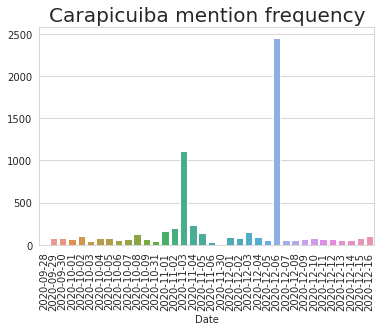

In [44]:
mydb = mysql_rds_database_authentication(twitter_database_credentials, 'twitter_data')

search = "carapicuiba"

df = pd.read_sql("SELECT * FROM tweets WHERE search LIKE '%{}%'".format(search), con=mydb)
df["date_date"] = [date.date() for date in df["date"]]
datas = df.groupby(by="date_date").count()

datas_values = datas["id"].values
datas_index = datas.index

sns.set_style("whitegrid")
plt.title("{} mention frequency".format(search.capitalize()), fontdict={"fontsize":20})
plot = sns.barplot(x=datas_index, y=datas_values)
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.show()

In [42]:
import mysql.connector
import os
import tweepy as tw
import pandas as pd
from datetime import datetime, timedelta
import numpy as np


def retrieve_last_300_tweets(search_word, twitter_api_credentials, database_credentials, database):

  api = twitter_authentication(twitter_api_credentials)


  start = datetime.now()
  tweets = tw.Cursor(api.search,
                    q=search_word,
                    tweet_mode="extended").items(300)

  count = 0

  # connect to mysql db
  mydb = mysql_rds_database_authentication(database_credentials, database)
  cursor = mydb.cursor()

  for tweet in tweets:
    if hasattr(tweet, "quoted_status"):
      full_text = "QT {} \n QUOTED: {}".format(tweet.full_text, tweet.quoted_status.full_text)    
    if hasattr(tweet, "retweeted_status") is False:
      full_text = "{}".format(tweet.full_text)
    if hasattr(tweet, "retweeted_status") is True:
      full_text = "RT @{}: {}".format(tweet.retweeted_status.user.screen_name, tweet.retweeted_status.full_text)
    
    sql =  """
      INSERT IGNORE INTO `tweets` (id, name, arroba, retweets, likes, text, date, location, hashtags, links, language, search)
      VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
      """

    cursor.execute(
          sql, (tweet.id_str, tweet.user.name, tweet.user.screen_name, tweet.retweet_count, tweet.favorite_count, full_text,
                tweet.created_at - timedelta(hours=3), tweet.user.location, str(tweet.entities.get("hashtags")), str(tweet.entities.get("urls")), tweet.lang, search_word)
      )

    
    count += 1

    # print(tweet.user.name, count)

  mydb.commit()

  end = datetime.now()
  time = end - start
  minutes = time.seconds / 60

  mydb.close()

  print("{}: retrieved {} in {}".format(word, count, np.round(time.seconds, 2)))

In [43]:
retrieve_last_300_tweets('carapicuiba', twitter_api_credentials, twitter_database_credentials, 'twitter_data')

carapicuíba: retrieved 300 in 22
